In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from boruta import BorutaPy
from lightgbm import LGBMClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [2]:

X_read = pd.read_csv('../source_data/secom/secom.data', sep='\s+', header=None)
X_read.columns = [f'feature{i+1}' for i in range(X_read.shape[1])]

y_read = pd.read_csv('../source_data/secom/secom_labels.data', sep='\s+', header=None)
y_read.columns = ['label', 'date_time']

X_train, X_test, y_train, y_test = train_test_split(X_read, y_read['label'], test_size=0.2, stratify=y_read['label'], random_state=42)


In [3]:

def drop_zero_variance_columns(df):
    return df.loc[:, df.var() != 0]

def drop_highly_correlated_columns(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    return df.drop(columns=to_drop)

def drop_feature_with_missing_values(df, threshold=0.45):
    missing_percentage = df.isnull().mean()
    to_drop = missing_percentage[missing_percentage > threshold].index
    return df.drop(columns=to_drop)

def cap_with_3s(df, threshold=3):
    return df.apply(lambda x: np.clip(x, x.mean() - threshold * x.std(), x.mean() + threshold * x.std()))


In [4]:

# Fix label encoding for LightGBM and XGBoost
# Convert -1 (normal) to 0, keep 1 (failure) as 1
y_train = y_train.replace({-1: 0, 1: 1})
y_test = y_test.replace({-1: 0, 1: 1})


In [5]:

def impute_missing_values(df, strategy='median'):
    if strategy == 'median':
        imputer = SimpleImputer(strategy='median')
    elif strategy == 'knn':
        imputer = KNNImputer()
    elif strategy == 'mice':
        imputer = IterativeImputer()
    else:
        raise ValueError("Invalid imputation strategy.")
    return pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

def scale_features(df, scaler='minmax'):
    if scaler == 'standard':
        scaler = StandardScaler()
    elif scaler == 'minmax':
        scaler = MinMaxScaler()
    elif scaler == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaler.")
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

def feature_selection_boruta(X, y, random_state=42):
    rf = RandomForestClassifier(n_estimators=100, random_state=random_state)
    boruta = BorutaPy(estimator=rf, n_estimators='auto', random_state=random_state)
    boruta.fit(X.values, y.values)
    return X.loc[:, boruta.support_]

def oversampling(X, y, strategy='smote'):
    if strategy == 'smote':
        sampler = SMOTE()
    elif strategy == 'adasyn':
        sampler = ADASYN()
    elif strategy == 'rose':
        sampler = RandomOverSampler()
    else:
        raise ValueError("Invalid oversampling strategy.")
    return sampler.fit_resample(X, y)


In [6]:

# Full preprocessing
X_train_p = drop_zero_variance_columns(X_train)
X_train_p = drop_highly_correlated_columns(X_train_p)
X_train_p = drop_feature_with_missing_values(X_train_p)

X_test_p = X_test[X_train_p.columns]

# Imputation
X_train_p = impute_missing_values(X_train_p, strategy='median')
X_test_p = impute_missing_values(X_test_p, strategy='median')

# Capping
X_train_p = cap_with_3s(X_train_p)
X_test_p = cap_with_3s(X_test_p)

# Scaling
X_train_p = scale_features(X_train_p, scaler='standard')
X_test_p = scale_features(X_test_p, scaler='standard')

# Feature selection
X_train_p = feature_selection_boruta(X_train_p, y_train)
X_test_p = X_test_p[X_train_p.columns]

# Oversample only training
X_resampled, y_resampled = oversampling(X_train_p, y_train, strategy='smote')

# Model with CV
model = LGBMClassifier(n_estimators=100, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring='f1')

print(f"Mean F1 Score (CV): {scores.mean():.4f}")
model.fit(X_resampled, y_resampled)


[LightGBM] [Info] Number of positive: 936, number of negative: 936
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 936, number of negative: 936
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 936, number of negative: 936
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

LGBMClassifier(random_state=42)

In [7]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'SVM': SVC(class_weight='balanced', probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=(y_resampled == -1).sum() / (y_resampled == 1).sum(), use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Dictionary to store metrics
results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_resampled, y_resampled)
    preds = model.predict(X_test_p)

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds, pos_label=1, zero_division=0),
        'Recall': recall_score(y_test, preds, pos_label=1, zero_division=0),
        'F1 Score': f1_score(y_test, preds, pos_label=1, zero_division=0)
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by='F1 Score', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df


[LightGBM] [Info] Number of positive: 1170, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 2340, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/aprajita/Desktop/Aprajita_SECOM/code/SECOM_DS2/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:10:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Accuracy,Precision,Recall,F1 Score
0,Naive Bayes,0.796178,0.147541,0.428571,0.219512
1,LightGBM,0.812102,0.148148,0.380952,0.213333
2,SVM,0.691083,0.112245,0.523810,0.184874
3,Random Forest,0.850318,0.117647,0.190476,0.145455
4,Logistic Regression,0.675159,0.082474,0.380952,0.135593
5,XGBoost,0.933121,0.000000,0.000000,0.000000


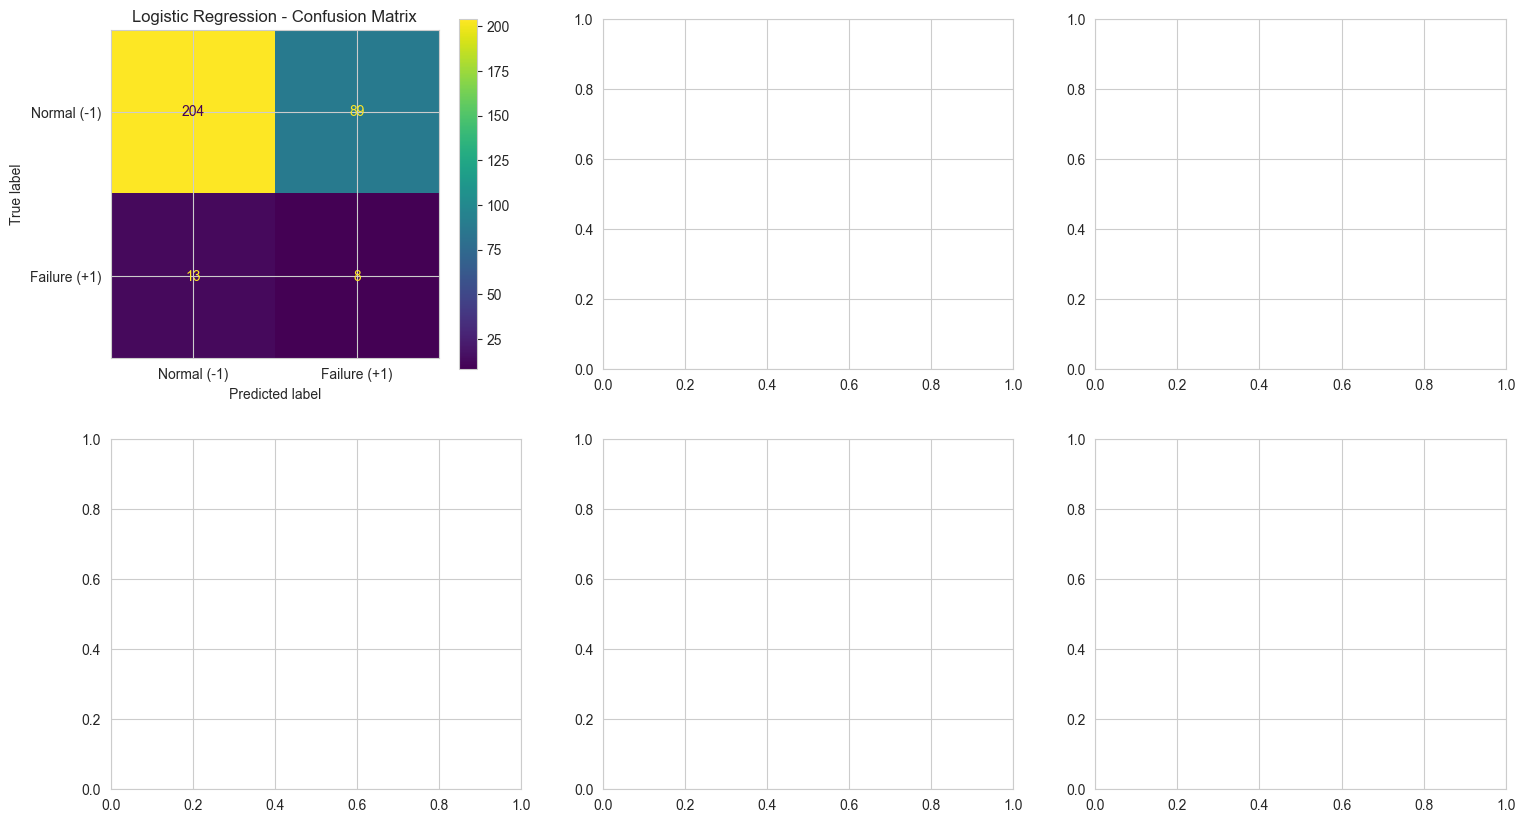

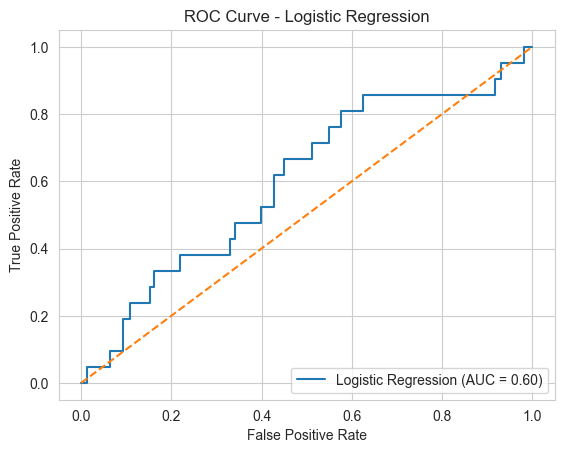

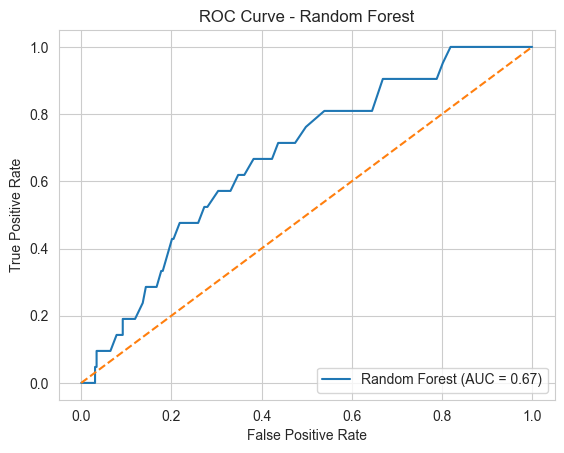

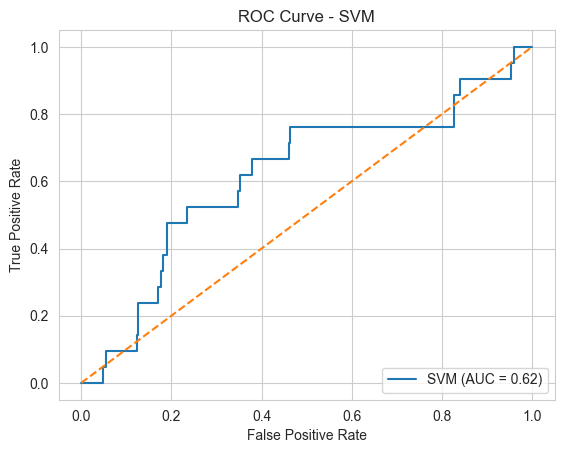

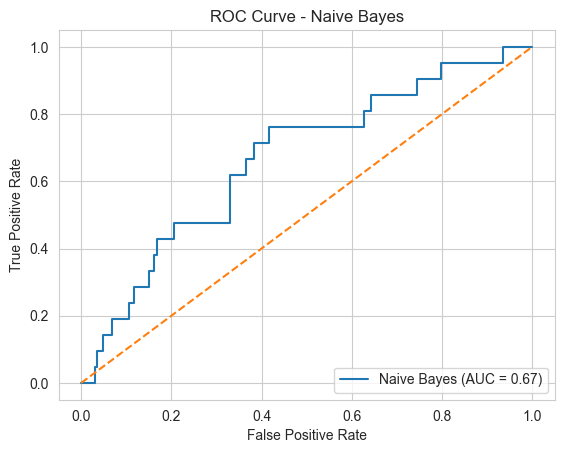

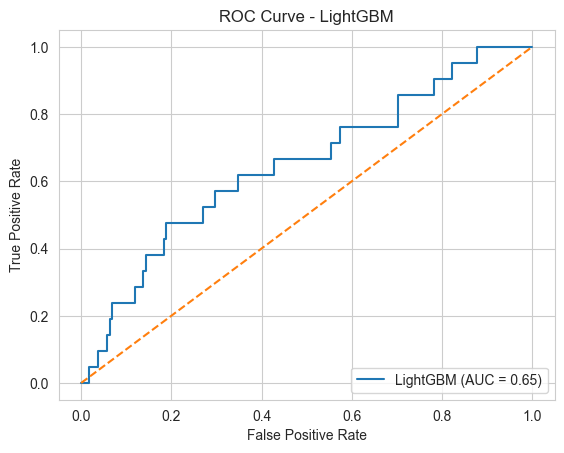

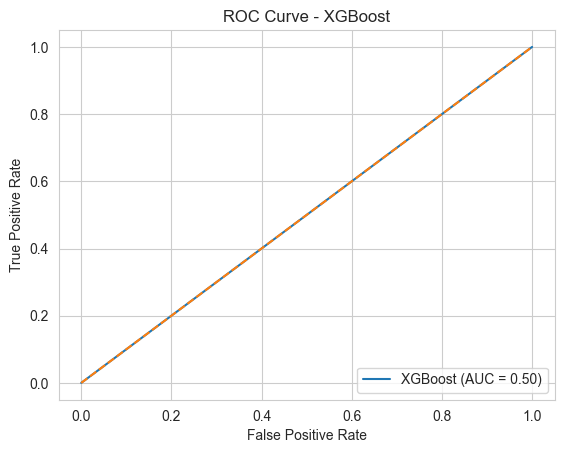

<Figure size 640x480 with 0 Axes>

In [8]:

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve

# Add ROC-AUC and confusion matrices
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    preds = model.predict(X_test_p)
    proba = model.predict_proba(X_test_p)[:, 1] if hasattr(model, "predict_proba") else None

    # Plot confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, preds, ax=axes[i], display_labels=['Normal (-1)', 'Failure (+1)'])
    axes[i].set_title(f"{name} - Confusion Matrix")

    # ROC-AUC score (only for models with probability)
    if proba is not None:
        auc_score = roc_auc_score(y_test, proba)
        fpr, tpr, _ = roc_curve(y_test, proba, pos_label=1)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {name}")
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

plt.tight_layout()


In [9]:

# Display summarized results table again
results_df = pd.DataFrame(results)
results_df.sort_values(by='F1 Score', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1 Score': '{:.4f}'
}).set_caption("Model Evaluation Metrics on SECOM Test Set")


,Model,Accuracy,Precision,Recall,F1 Score
0,Naive Bayes,0.7962,0.1475,0.4286,0.2195
1,LightGBM,0.8121,0.1481,0.3810,0.2133
2,SVM,0.6911,0.1122,0.5238,0.1849
3,Random Forest,0.8503,0.1176,0.1905,0.1455
4,Logistic Regression,0.6752,0.0825,0.3810,0.1356
5,XGBoost,0.9331,0.0000,0.0000,0.0000


In [10]:

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
import numpy as np

def tune_threshold(model, X, y_true):
    if not hasattr(model, "predict_proba"):
        return None, None, None  # Skip if model doesn't support probabilities

    probs = model.predict_proba(X)[:, 1]
    thresholds = np.arange(0.0, 1.01, 0.01)
    f1s = [f1_score(y_true, probs >= t) for t in thresholds]

    best_idx = np.argmax(f1s)
    best_thresh = thresholds[best_idx]
    best_preds = (probs >= best_thresh).astype(int)
    return best_thresh, best_preds, f1s[best_idx]


In [11]:

# Redefine model dictionary with XGBoost fix
from xgboost import XGBClassifier

scale_weight = (y_resampled == 0).sum() / (y_resampled == 1).sum()

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'SVM': SVC(class_weight='balanced', probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=scale_weight, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Store metrics
results = []

for name, model in models.items():
    model.fit(X_resampled, y_resampled)

    # Default predictions at 0.5
    preds = model.predict(X_test_p)

    # Threshold tuning
    best_thresh, tuned_preds, best_f1 = tune_threshold(model, X_test_p, y_test)
    if tuned_preds is not None:
        preds = tuned_preds

    results.append({
        'Model': name,
        'Best Threshold': best_thresh if best_thresh else '0.5',
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds, pos_label=1, zero_division=0),
        'Recall': recall_score(y_test, preds, pos_label=1, zero_division=0),
        'F1 Score': f1_score(y_test, preds, pos_label=1, zero_division=0)
    })


[LightGBM] [Info] Number of positive: 1170, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 2340, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/aprajita/Desktop/Aprajita_SECOM/code/SECOM_DS2/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:10:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [12]:

results_df = pd.DataFrame(results)
results_df.sort_values(by='F1 Score', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)

results_df.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1 Score': '{:.4f}'
}).set_caption("Threshold-Tuned Model Metrics on SECOM Test Set")


,Model,Best Threshold,Accuracy,Precision,Recall,F1 Score
0,LightGBM,0.420000,0.7898,0.1538,0.4762,0.2326
1,Naive Bayes,0.520000,0.8057,0.1552,0.4286,0.2278
2,SVM,0.560000,0.7834,0.1493,0.4762,0.2273
3,XGBoost,0.300000,0.7643,0.1370,0.4762,0.2128
4,Random Forest,0.380000,0.7611,0.1351,0.4762,0.2105
5,Logistic Regression,0.580000,0.7994,0.1250,0.3333,0.1818


In [13]:

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define your preprocessing choices
imputation_strategy = 'median'
scaling_strategy = 'standard'
oversampling_strategy = 'smote'

# Use StratifiedKFold CV on full dataset (not holding out X_test anymore)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create dataset from full X_read and y_read
X_full = X_read.copy()
y_full = y_read['label'].replace({-1: 0, 1: 1})

# Apply preprocessing to all data (no split)
X_full = drop_zero_variance_columns(X_full)
X_full = drop_highly_correlated_columns(X_full)
X_full = drop_feature_with_missing_values(X_full)

X_full = impute_missing_values(X_full, strategy=imputation_strategy)
X_full = cap_with_3s(X_full)
X_full = scale_features(X_full, scaler=scaling_strategy)
X_full = feature_selection_boruta(X_full, y_full)

X_results, y_results = oversampling(X_full, y_full, strategy=oversampling_strategy)

# Models
scale_weight = (y_results == 0).sum() / (y_results == 1).sum()
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'SVM': SVC(class_weight='balanced', probability=True, random_state=42),
    'NaiveBayes': GaussianNB(),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=scale_weight, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Evaluate all models via cross_val_predict
results = []
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        probs = cross_val_predict(model, X_results, y_results, cv=cv, method='predict_proba')[:, 1]
        thresholds = np.arange(0.0, 1.01, 0.01)
        f1s = [f1_score(y_results, probs >= t) for t in thresholds]
        best_idx = np.argmax(f1s)
        best_thresh = thresholds[best_idx]
        preds = (probs >= best_thresh).astype(int)
    else:
        preds = cross_val_predict(model, X_results, y_results, cv=cv)
        best_thresh = 'default'

    results.append({
        'Model': f"{imputation_strategy}_{scaling_strategy}_{oversampling_strategy}_{name}",
        'Best Threshold': best_thresh,
        'Accuracy': accuracy_score(y_results, preds),
        'Precision': precision_score(y_results, preds, zero_division=0),
        'Recall': recall_score(y_results, preds, zero_division=0),
        'F1 Score': f1_score(y_results, preds, zero_division=0)
    })


KeyboardInterrupt: 

In [ ]:

results_df = pd.DataFrame(results)
results_df.sort_values(by='F1 Score', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)

results_df.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1 Score': '{:.4f}'
}).set_caption("Cross-Validation Metrics with Strategy-Model Names")
